# Exercise 8
## 2  Non-negative matrix factorization
### Setup

In [116]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.datasets import load_digits
from sklearn import decomposition
digits = load_digits ()
X = digits ["data" ]/255.
Y = digits ["target"]

### 2.1 Comparison of scikit-learn's NMF with SVD

In [142]:
def largestNIndices(a,n,axis=1):
    ind=np.unravel_index(a.flatten().argsort()[::-1],a.shape)[axis]
    return np.argsort(np.unique(ind,return_index=True)[1])[:n]

In [165]:
def plotEigVec(v):
    fig=plt.figure(figsize=(9,6))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(v[i].reshape(8,8),cmap='gray')
        plt.title(i+1)
        plt.axis('off')

In [181]:
#SVD
Xmean=np.mean(X,axis=0)
X_tilde=X-Xmean
u,s,vh=np.linalg.svd(X_tilde)
#row indices for the 6 largest values in vh
#save in SVD_mir (most important rows)
SVD_mir=largestNIndices(vh,6,1)
svdBasis=vh.T[SVD_mir]+Xmean

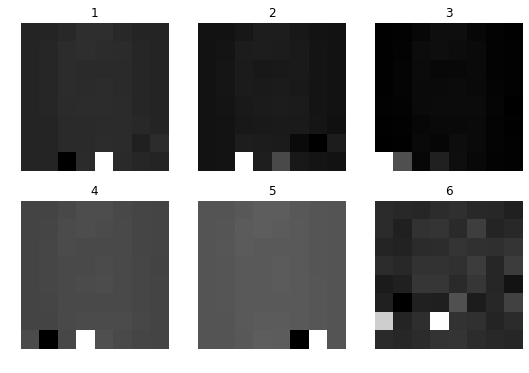

In [182]:
plotEigVec(svdBasis)

In [192]:
#sklearn's NMF
nmf=decomposition.NMF(n_components=10, init='random',random_state=0)
Z=nmf.fit_transform(X)
H=nmf.components_
NMF_mir=largestNIndices(H,6,0)

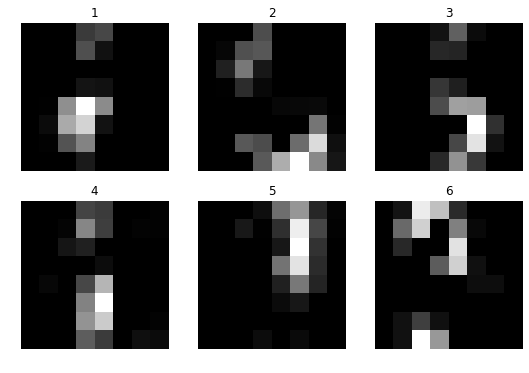

In [193]:
plotEigVec(H[NMF_mir])

### 2.2 Implementation

In [14]:
def non_negative(data,num_components,T=1000,returnLoss=False):
    X=data
    a,b=X.shape
    #initialize  H,Z:
    H_t,Z_t=np.abs(np.random.normal(size=(num_components,b))),np.abs(np.random.normal(size=(a,num_components)))
    #initialize updated H,Z
    H,Z=None,None
    #squared loss
    loss=[]
    for t in range(T):
        H=np.multiply(H_t,np.divide(Z_t.T@X,np.clip(Z_t.T@Z_t@H_t,1e-6,None)))
        Z=np.multiply(Z_t,np.divide(X@H.T,np.clip(Z_t@H@H.T,1e-6,None)))
        H_t,Z_t=H,Z
        loss.append(np.linalg.norm(X-Z_t@H_t)**2)
    return (H_t,Z_t,loss) if returnLoss else (H_t,Z_t)

In [15]:
h,z,l=non_negative(X,6,returnLoss=True)

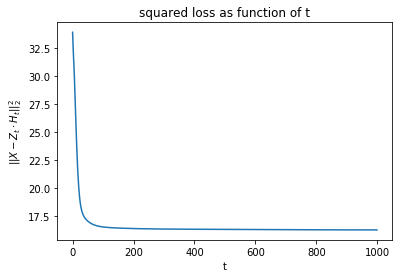

In [19]:
plt.plot(l)
plt.title('squared loss as function of t')
plt.xlabel('t')
plt.ylabel('$||X-Z_t\cdot H_t||^2_2$')
plt.show()

In [24]:
np.count_nonzero(np.gradient(l)>0)

0

That shows that the squared loss is non-increasing with $t$.

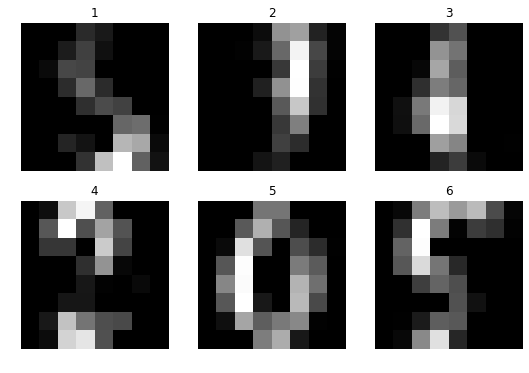

In [194]:
plotEigVec(h[largestNIndices(h,6,0)])

looks similar to the NMF result using <tt>scikit-learn</tt>

## 3 Recommender system

In [3]:
import pandas as pd # install pandas via conda
# column headers for the dataset
ratings_cols = ['user id ','movie id ','rating ','timestamp ']
movies_cols = ['movie id ','movie title ','release date ',
'video release date ','IMDb URL ','unknown ','Action ',
'Adventure ','Animation ','Childrens ','Comedy ','Crime ',
' Documentary ','Drama ','Fantasy ','Film- Noir ','Horror ',
'Musical ','Mystery ','Romance ','Sci-Fi ','Thriller ',
'War ' ,'Western ']
users_cols = ['user id ','age ','gender ','occupation ','zip code ']
users = pd.read_csv('ml-100k/u.user ', sep ='|',names = users_cols , encoding ='latin-1 ')
movies = pd.read_csv('ml-100k/u.item ', sep='|',names = movies_cols , encoding ='latin-1 ')

ratings = pd.read_csv('ml-100k/u.data ', sep ='\t',names = ratings_cols , encoding ='latin-1 ')
# peek at the dataframes , if you like :)
users.head()
movies.head()
ratings.head()
# create a joint ratings dataframe for the matrix
fill_value = 0
rat_df = ratings.pivot(index = 'user id ',
columns ='movie id ', values = 'rating ').fillna(fill_value)
rat_df.head()

movie id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
